# Simple RNN
$$ x_t = ln(X_t)$$
$$ h_t = tanh(W_{xh}x_t + U_{hh}h_{t-1} + b_h) $$
$$ \hat{\mu}_t = A_{hy}h_t + b_y $$
$$ \hat{\sigma}_t^2 = \omega + \alpha x_t^2 + \beta \hat{\sigma}_{t-1}^2$$
$$ w_t = tanh(\kappa \frac{\hat{\mu}}{\hat{\sigma}_t^2}) $$
$$ r_t = w_tR_t - c|w_t - w_{t-1}|$$
$$ \mathscr{L} = -\mathbb{E}[r_t] + \lambda\mathbb{V}[r_t] = -\frac{1}{T}\sum{r_t} + \lambda\frac{1}{T}\sum{[r_t - \frac{1}{T}\sum{r_t}]^2}$$

In [7]:
import numpy as np
import torch
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import os

from Quant.RNN import RNN
import Quant.TS_utils as TS


In [8]:
# Initialize Weights and Biases
Nx = 20
Nh = 20
Ny = 1



In [9]:
# Download SPY data
ticker = "SPY"
start_date = "2018-01-01"

data = yf.download(ticker, start=start_date)
data['LogReturns'] = np.log(data['Close'] / data['Close'].shift(1))
data = data.dropna()
data['NormalizedLogReturns'] = (data['LogReturns'] - data['LogReturns'].mean()) / data['LogReturns'].std()

# Set up training parameters
split_ratio = 0.8
split_idx = int(len(data) * split_ratio)
batch_size = 128

print(f"Downloaded {len(data)} days of data for {ticker}")
print(f"Training on {split_idx} samples, testing on {len(data) - split_idx} samples")

C:\Users\adamd\AppData\Local\Temp\ipykernel_25484\2236777566.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date)
[*********************100%***********************]  1 of 1 completed

Downloaded 1966 days of data for SPY
Training on 1572 samples, testing on 394 samples


In [10]:
module = RNN.RNNCell(Nx, Nh, Ny, nntype='LSTM').to("cuda")

# load params
if os.path.exists("lstm_model.pth"):
    module.load("lstm_model.pth")
    print("Weights Loaded")



# Create dataset directly from the DataFrame
train_df = data.iloc[:split_idx]
train_dates = train_df.index
logret = torch.tensor(train_df['LogReturns'].values, dtype=torch.float32).unsqueeze(1).to("cuda")
normlogret = torch.tensor(train_df['NormalizedLogReturns'].values, dtype=torch.float32).unsqueeze(1).to("cuda")

dataset = torch.utils.data.TensorDataset(logret, normlogret)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

print(f"Dataset tensors: logret shape = {logret.shape}, normlogret shape = {normlogret.shape}")


# module.fit_garch(normlogret)
module.train_RNN(dataloader, epochs=10, lr=0.00004) 

print(module)

module.save("lstm_model.pth")

Weights Loaded
Dataset tensors: logret shape = torch.Size([1572, 1]), normlogret shape = torch.Size([1572, 1])
LSTM: Epoch 1/10, Loss: 4.2930, Sharpe: 0.1085, Cumulative Return: 0.4116%, Mean Return: 0.00026465%, Volatility: 0.03792829, W Mean: -0.01220250, W std: 1.59526324
LSTM: Epoch 2/10, Loss: 1.8547, Sharpe: 0.1941, Cumulative Return: 0.7422%, Mean Return: 0.00047648%, Volatility: 0.03823264, W Mean: -0.01233234, W std: 1.60548699
LSTM: Epoch 3/10, Loss: 0.9984, Sharpe: 0.1857, Cumulative Return: 0.7225%, Mean Return: 0.00046388%, Volatility: 0.03889936, W Mean: -0.01372649, W std: 1.66823161
LSTM: Epoch 4/10, Loss: 0.8991, Sharpe: 0.0935, Cumulative Return: 0.3689%, Mean Return: 0.00023728%, Volatility: 0.03945052, W Mean: -0.01430753, W std: 1.70535457
LSTM: Epoch 5/10, Loss: -0.1707, Sharpe: 0.1922, Cumulative Return: 0.7645%, Mean Return: 0.00049069%, Volatility: 0.03976783, W Mean: -0.01456194, W std: 1.72222447
LSTM: Epoch 6/10, Loss: 0.3608, Sharpe: -0.0168, Cumulative Ret

In [11]:
module.by.item()

0.0037840702570974827

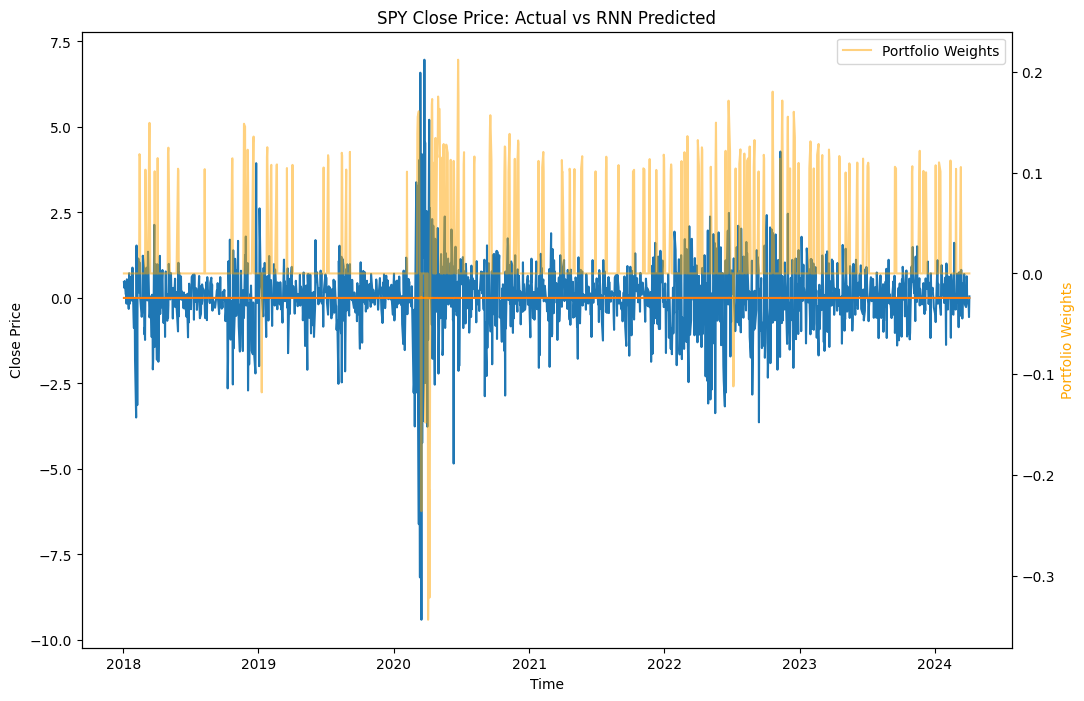

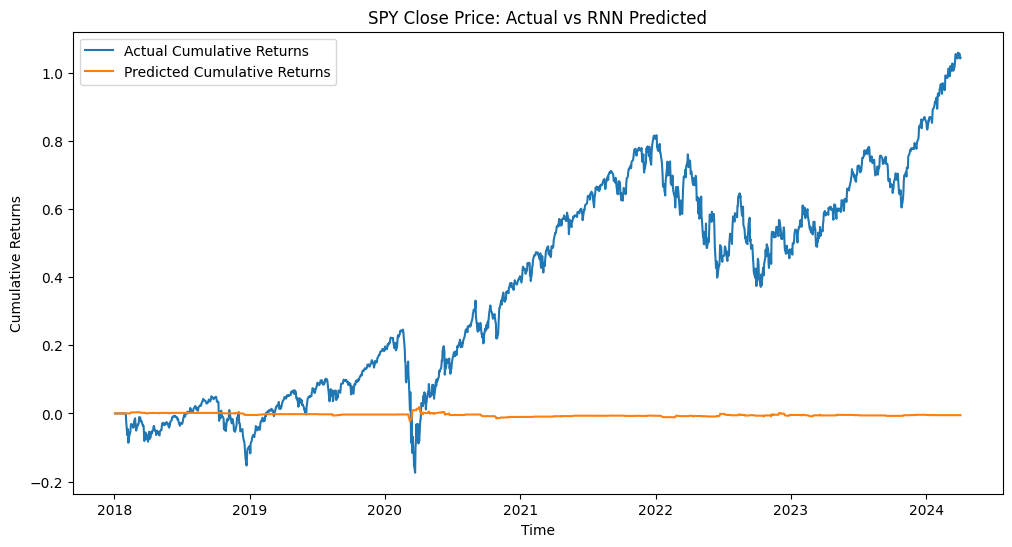

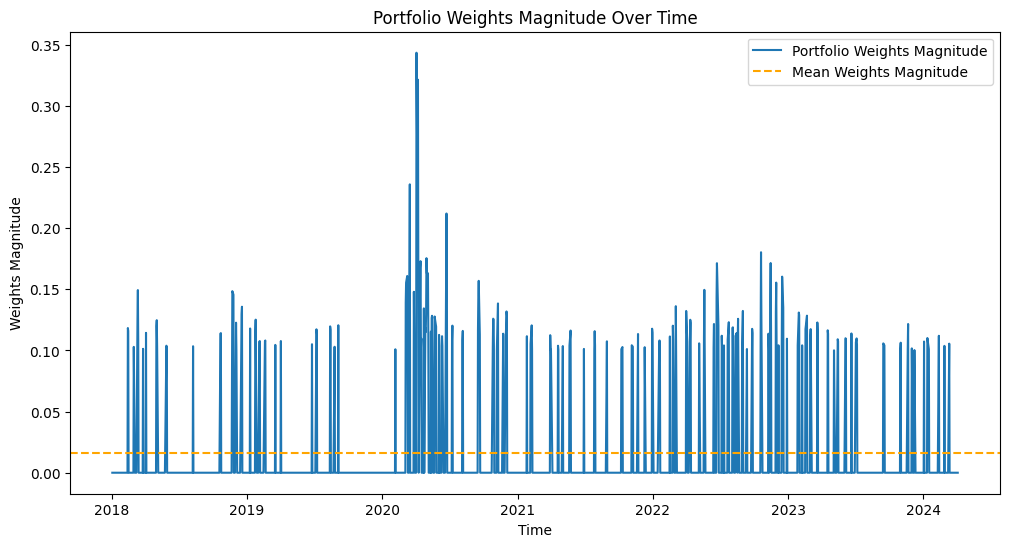

In [12]:
def func2series(func, dates, data1, data2=None):
    if data2 is None:
        return pd.Series(np.concatenate([np.zeros(Nx), func(data1).cpu().detach().numpy().flatten()], axis=0), index=dates)
    else:
        return pd.Series(np.concatenate([np.zeros(Nx), func(data1, data2).cpu().detach().numpy().flatten()], axis=0), index=dates)

returns = func2series(module.compute_return, train_dates, logret, normlogret)
w = func2series(module.compute_wt, train_dates, normlogret)



fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(train_df['NormalizedLogReturns'], label='Actual')
ax1.plot(returns, label='Predicted')
plt.title('SPY Close Price: Actual vs RNN Predicted')
plt.xlabel('Time')
ax1.set_ylabel('Close Price')
ax2 = ax1.twinx()
ax2.plot(w, color='orange', label='Portfolio Weights', alpha=0.5)
ax2.set_ylabel('Portfolio Weights', color='orange')
plt.legend()
plt.show()


# Cummulative returns plot
plt.figure(figsize=(12, 6))
plt.plot(func2series(TS.compute_cumulative_return_from_log, train_dates, torch.tensor(train_df['LogReturns'].values[Nx:])), label='Actual Cumulative Returns')
plt.plot(func2series(TS.compute_cumulative_return_from_log, train_dates, torch.tensor(returns.values[Nx:])), label='Predicted Cumulative Returns')
plt.title('SPY Close Price: Actual vs RNN Predicted')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(abs(w), label='Portfolio Weights Magnitude')
plt.axhline(abs(w).mean(), color='orange', linestyle='--', label='Mean Weights Magnitude')
plt.title('Portfolio Weights Magnitude Over Time')
plt.xlabel('Time')
plt.ylabel('Weights Magnitude')
plt.legend()
plt.show()